In [ ]:
#necessary libraries
import os
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import classification_report

In [ ]:
#functions to load the images and corresponding labels

def load_normal(norm_path):
    norm_files = np.array(os.listdir(norm_path))
    norm_labels = np.array([0]*len(norm_files))
    norm_images = []
    
    for image in tqdm(norm_files):
        image = cv2.imread(norm_path + image)
        image = cv2.resize(image, dsize=(224,224))
        image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        image = clahe(image)
        norm_images.append(image)
        
    norm_images = np.array(norm_images)
    
    return norm_images, norm_labels   
     
def load_pneumonia(pneu_path):
    pneu_files = np.array(os.listdir(pneu_path))
    pneu_labels = np.array([1]*len(pneu_files))
    
    pneu_images = []
    for image in tqdm(pneu_files):
        image = cv2.imread(pneu_path + image)
        image = cv2.resize(image, dsize=(224,224))
        image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        image = clahe(image)
        pneu_images.append(image)
        
    pneu_images = np.array(pneu_images)
    
    return pneu_images, pneu_labels


#function for displaying random images from the training set

def display_random_images():
    fig, axes = plt.subplots(ncols=7, nrows=2, figsize=(16, 4))

    indices = np.random.choice(len(X_train), 14)
    counter = 0
    
    for i in range(2):
        for j in range(7):
            axes[i,j].set_title(Y_train[indices[counter]])
            axes[i,j].imshow(X_train[indices[counter]], cmap='gray')
            axes[i,j].get_xaxis().set_visible(False)
            axes[i,j].get_yaxis().set_visible(False)
            counter += 1
    plt.show()

#function for applying adaptive histogram equalisation on data

def clahe(image):
    clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8,8))
    image = clahe.apply(image)
    return image


def visualize_training_results(results):
    history = results.history
    
    for m in ['loss', 'accuracy', 'precision', 'recall']:
        plt.figure(figsize=(15, 5))
        plt.plot(history[m], label='Training', marker='o', color='blue')
        plt.plot(history[f'val_{m}'], label='Validation', marker='o', color='red')
        plt.xlabel('Epochs')
        plt.legend()
        plt.title(m.title())
    
    plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#invoking the predefined functions to load the training data
norm_images, norm_labels = load_normal('/content/drive/MyDrive/Colab Notebooks/chest_xray1/train/NORMAL/')
pneu_images, pneu_labels = load_pneumonia('/content/drive/MyDrive/Colab Notebooks/chest_xray1/train/PNEUMONIA/')

#norm_images and pneu_images are going to be our X train while the rest is going to be Y trian.
X_train = np.append(norm_images, pneu_images, axis=0)
Y_train = np.append(norm_labels,pneu_labels)

#scaling the training data to have values between 0 and 1
X_train = X_train.astype(float)/255.0

In [ ]:
#displaying random images from the training set
display_random_images()

In [ ]:
#invoking the predefined functions to load the testing data
norm_images_test, norm_labels_test = load_normal('/content/drive/MyDrive/Colab Notebooks/chest_xray1/test/NORMAL/')
pneu_images_test, pneu_labels_test = load_pneumonia('/content/drive/MyDrive/Colab Notebooks/chest_xray1/test/PNEUMONIA/')

#norm_imagestest and pneu_images_test are going to be our X test while the rest is going to be Y test.
X_test = np.append(norm_images_test, pneu_images_test, axis=0)
Y_test = np.append(norm_labels_test, pneu_labels_test)

#scaling the test data to have values between 0 and 1
X_test = X_test.astype(float)/255.0

In [ ]:
# Specify the directory path
directory = '/content/drive/MyDrive/Colab Notebooks/'

# Create the full file path with the directory and file name
file_path = os.path.join(directory, 'SCANIA_data.pickle')

In [ ]:
#use this to save variables
with open(file_path, 'wb') as file:
    pickle.dump((X_train, X_test, Y_train, Y_test), file)

In [ ]:
#use this to load variables
with open(file_path, 'rb') as file:
    X_train, X_test, Y_train, Y_test = pickle.load(file)

In [ ]:

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

X_train = np.repeat(X_train, 3, axis=-1)
X_test = np.repeat(X_test, 3, axis=-1)

In [ ]:
print(X_train.shape)
print(X_test.shape)

In [ ]:
#data augmentation 

datagen = ImageDataGenerator(
        rotation_range = 10,  
        zoom_range = 0.1, 
        width_shift_range = 0.1, 
        height_shift_range = 0.1,
        horizontal_flip = True
        )

datagen.fit(X_train)
train_gen = datagen.flow(X_train, Y_train, batch_size=32, shuffle=True, seed = 42)
test_gen = datagen.flow(X_test,Y_test,batch_size=32, shuffle=True, seed = 42)

# **Model Building**


In [ ]:
pretrained_model = ResNet50(
    input_shape = (224,224,3),
    include_top = False,
    weights = 'imagenet',
    pooling = 'avg'
)
pretrained_model.trainable = False

# Create a new model architecture
inputs = pretrained_model.input
x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

# Create the modified model
model = Model(inputs=inputs, outputs=outputs)

for layer in pretrained_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(lr=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])

my_callbacks = EarlyStopping(monitor = 'val_accuracy',
                             min_delta = 0,
                             patience = 5,
                             mode = 'auto')
history = model.fit(train_gen,
                    epochs=20,
                    validation_data=test_gen)

model 0

In [ ]:
pretrained_model = ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

inputs = pretrained_model.input

x = pretrained_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)

outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

my_callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
]

history = model.fit(train_gen, 
                    epochs=30, 
                    validation_data=(X_test, Y_test),
                    callbacks=my_callbacks)

model1

In [ ]:
pretrained_model = ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = True  # Unfreeze all layers

inputs = pretrained_model.input
x = pretrained_model.output

x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
my_callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
]

history = model.fit(train_gen, 
                    epochs=30, 
                    validation_data=(X_test, Y_test),
                    callbacks=my_callbacks)


model 2

In [ ]:
pretrained_model = ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

inputs = pretrained_model.input

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dense(128, activation='relu')(x)

outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

my_callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
]

history = model.fit(train_gen, 
                    epochs=20, 
                    validation_data=(X_test, Y_test),
                    callbacks=my_callbacks)

model3


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

pretrained_model = ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dense(128, activation='relu')(x)

outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=pretrained_model.input, outputs=outputs)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

my_callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
]

history = model.fit(train_gen, 
                    epochs=20, 
                    validation_data=(X_test, Y_test),
                    callbacks=my_callbacks)

model4

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load pre-trained ResNet50 model
pretrained_model = ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

pretrained_model.trainable = False

# Add custom layers
x = pretrained_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)

outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs=pretrained_model.input, outputs=outputs)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

my_callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
]

history = model.fit(train_gen,
                    epochs=20,
                    validation_data=(X_test, Y_test),
                    callbacks=my_callbacks)


model latest



In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

pretrained_model = ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

inputs = pretrained_model.input

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.3)(x)  # Adding dropout regularization
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)  # Adding dropout regularization

outputs = Dense(1, activation='sigmoid')(x)

model2 = Model(inputs=inputs, outputs=outputs)

model2.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

my_callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
]

history = model2.fit(train_gen, 
                    epochs=20, 
                    validation_data=test_gen,
                    )

In [ ]:
model.save('scania.h5')

In [ ]:
# Plot accuracy
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Accuracy')
plt.show()

# Plot loss
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title('Loss')
plt.show()

In [ ]:
results = model2.evaluate(test_gen, verbose=0)
print("    Test Loss : {:.5f}".format(results[0]))
print("Test Accuracy : {:.2f}%".format(results[1]*100))

# **STARTING FROM SCRATCH**

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Colab Notebooks/chest_xray1/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from PIL import Image
import cv2

In [ ]:
load_img('/content/drive/MyDrive/Colab Notebooks/chest_xray1/train/NORMAL/IM-0461-0001.jpeg')

In [ ]:
load_img('/content/drive/MyDrive/Colab Notebooks/chest_xray1/train/PNEUMONIA/person1392_bacteria_3538.jpeg')

In [ ]:
img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/chest_xray1/train/PNEUMONIA/person1412_bacteria_3612.jpeg')

In [ ]:
print(img.shape)

(784, 1256, 3)


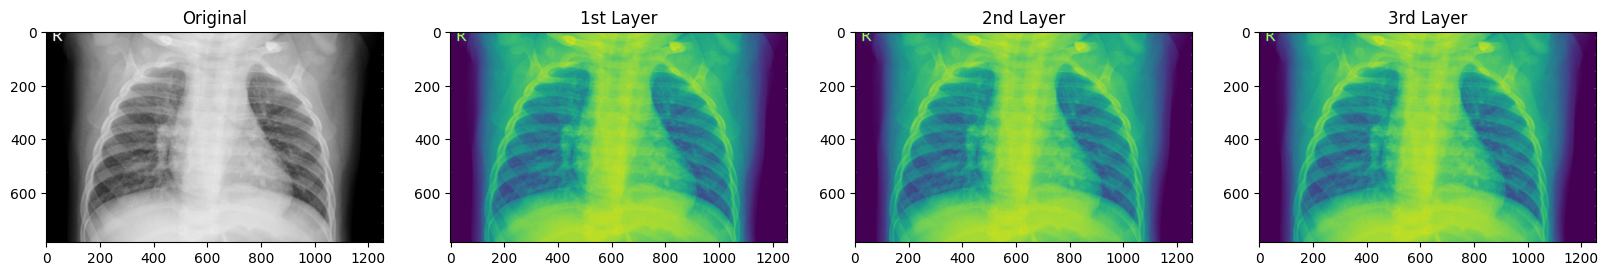

In [ ]:
# DISPLAYING THE FIRST LAYER
fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
ax1.imshow(img)
ax1.set_title('Original')

ax2.imshow(img[:, :, 0])
ax2.set_title('1st Layer')

ax3.imshow(img[:, :, 1])
ax3.set_title('2nd Layer')

ax4.imshow(img[:, :, 2])
ax4.set_title('3rd Layer');

In [3]:
import os
import glob
from pathlib import Path

In [4]:
# GET THE DIRECTORY TO THE DATASETS
path_data = '/content/drive/MyDrive/Colab Notebooks/chest_xray1'
path_train = os.path.join(path_data, 'train')
path_val = os.path.join(path_data, 'val')
path_test = os.path.join(path_data, 'test')

# INITIATE EMPTY LIST OF TRAINING DATA
# THAT WILL BE CONVERTED TO PANDAS DATAFRAME LATER
data_train = []
data_val = []
data_test = []
data = [data_train, data_val, data_test]

# ITERATE THROUGH EACH PATH
for i, d in enumerate([path_train, path_val, path_test]):
    # GET THE PATH TO EACH FOLDER - NORMAL AND PNEUMONIA
    normal = os.path.join(d, 'NORMAL')
    pneumonia = os.path.join(d, 'PNEUMONIA')
    
    # FETCH ALL .jpeg FILES
    normal_imgs = Path(normal).glob('*.jpeg')
    pneumonia_imgs = Path(pneumonia).glob('*.jpeg')
    
    # APPEND THE NAME AND CORRESPONDING LABEL (BASED ON FOLDER NAME)
    # TO data_train list AS TUPLES
    for img in normal_imgs:
        data[i].append((str(img), 0))
    
    for img in pneumonia_imgs:
        data[i].append((str(img), 1))

In [5]:
# CONVERT data_train TO DATAFRAME FOR EASY MANIPULATION
columns = ['image', 'label']
train_df = pd.DataFrame(data_train, columns=columns)
val_df = pd.DataFrame(data_val, columns=columns)
test_df = pd.DataFrame(data_test, columns=columns)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5240 entries, 0 to 5239
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   5240 non-null   object
 1   label   5240 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 82.0+ KB


In [ ]:
train_df.label.value_counts()

1    3894
0    1346
Name: label, dtype: int64

In [ ]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   16 non-null     object
 1   label   16 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 384.0+ bytes


In [ ]:
val_df.label.value_counts()

0    8
1    8
Name: label, dtype: int64

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624 entries, 0 to 623
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   624 non-null    object
 1   label   624 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 9.9+ KB


In [6]:
# CONCAT train_df and val_df
master_df = pd.concat([train_df, val_df])
# RESET INDEX (SO THERE WON'T BE ANY DUPLICATED INDICES) BY DROPPING OLD ONES
master_df.reset_index(inplace=True, drop=True)

In [ ]:
master_df.tail(20)

,image,label
5236,/content/drive/MyDrive/Colab Notebooks/chest_x...,1
5237,/content/drive/MyDrive/Colab Notebooks/chest_x...,1
5238,/content/drive/MyDrive/Colab Notebooks/chest_x...,1
5239,/content/drive/MyDrive/Colab Notebooks/chest_x...,1
5240,/content/drive/MyDrive/Colab Notebooks/chest_x...,0
5241,/content/drive/MyDrive/Colab Notebooks/chest_x...,0
5242,/content/drive/MyDrive/Colab Notebooks/chest_x...,0
5243,/content/drive/MyDrive/Colab Notebooks/chest_x...,0
5244,/content/drive/MyDrive/Colab Notebooks/chest_x...,0
5245,/content/drive/MyDrive/Colab Notebooks/chest_x...,0


In [ ]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5256 entries, 0 to 5255
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   5256 non-null   object
 1   label   5256 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 82.2+ KB


In [7]:
# CHECK FOR DUPLICATES
master_df.duplicated().any()

False

In [ ]:
master_df.sample(10, random_state=42)

,image,label
3298,/content/drive/MyDrive/Colab Notebooks/chest_x...,1
1782,/content/drive/MyDrive/Colab Notebooks/chest_x...,1
3655,/content/drive/MyDrive/Colab Notebooks/chest_x...,1
577,/content/drive/MyDrive/Colab Notebooks/chest_x...,0
718,/content/drive/MyDrive/Colab Notebooks/chest_x...,0
8,/content/drive/MyDrive/Colab Notebooks/chest_x...,0
157,/content/drive/MyDrive/Colab Notebooks/chest_x...,0
23,/content/drive/MyDrive/Colab Notebooks/chest_x...,0
1694,/content/drive/MyDrive/Colab Notebooks/chest_x...,1
4549,/content/drive/MyDrive/Colab Notebooks/chest_x...,1


In [ ]:
master_df.label.value_counts()

1    3902
0    1354
Name: label, dtype: int64

In [8]:
master_df.label.value_counts(normalize=True)

1    0.74239
0    0.25761
Name: label, dtype: float64

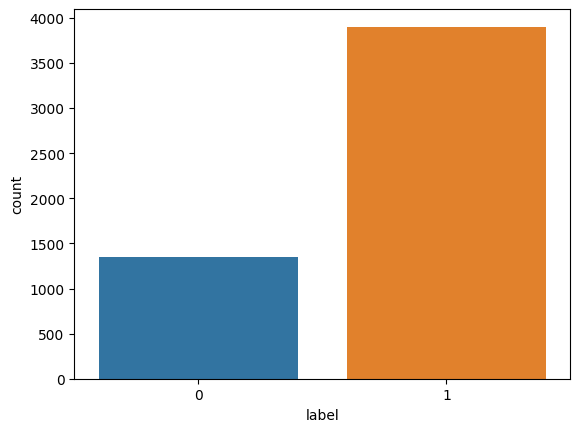

In [ ]:
sns.countplot(x='label', data=master_df);

In [9]:
def cat_pneumonia_type(x):
    if 'bacteria' in x:
        output = 'bacteria'
    elif 'virus' in x:
        output = 'virus'
    else:
        output = 'normal'
    return output

In [10]:

master_df['type'] = master_df.image.apply(lambda x: cat_pneumonia_type(x))

In [11]:
master_df.type.value_counts()

bacteria    2545
virus       1357
normal      1354
Name: type, dtype: int64

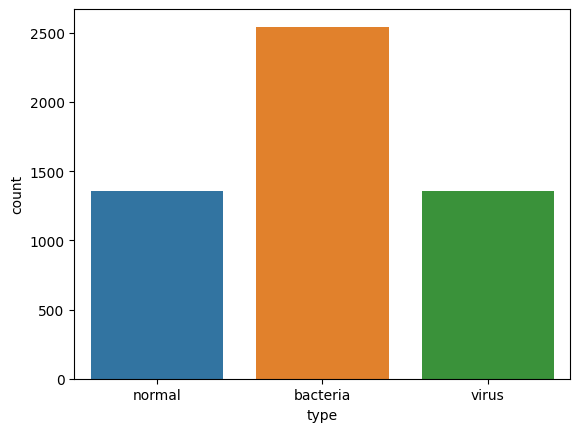

In [ ]:
sns.countplot(x='type', data=master_df);

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
# TRAIN VALIDATION SPLIT
train_df, val_df = train_test_split(master_df, test_size=0.2, random_state=42)

In [14]:
# MAKING SURE NONE OF THE SAMPLES IN val_df IS ALSO IN train_df
# TO AVOID DATA LEAKAGE
len(set(val_df.index) - set(train_df.index)) == len(val_df)

True

 **Data Generators**

In [15]:
BATCH_SIZE = 32

# CREATE GENERATOR FOR TRAINING DATA (FROM train_df DATAFRAME)
train_generator = ImageDataGenerator(rescale=1.0/255).flow_from_dataframe(
    dataframe=train_df, x_col='image', y_col='label',
    color_mode='grayscale',
    class_mode='raw',
    target_size=(180,180), 
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True   # shuffle so we're not missing out on any samples
)

# CREATE GENERATOR FOR VALIDATION DATA (FROM val_df DATAFRAME)
val_generator = ImageDataGenerator(rescale=1.0/255).flow_from_dataframe(
    dataframe=val_df, x_col='image', y_col='label',
    color_mode='grayscale',
    class_mode='raw',
    target_size=(180,180), 
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True
)

Found 4204 validated image filenames.
Found 1052 validated image filenames.


In [16]:
# CHECKING THE SHAPE OF 1 BATCH OF THE train_generator
images_train, labels_train = next(train_generator)
print(f'Training set: {images_train.shape} | {labels_train.shape}')

Training set: (32, 180, 180, 1) | (32,)


Dataset Visualisation

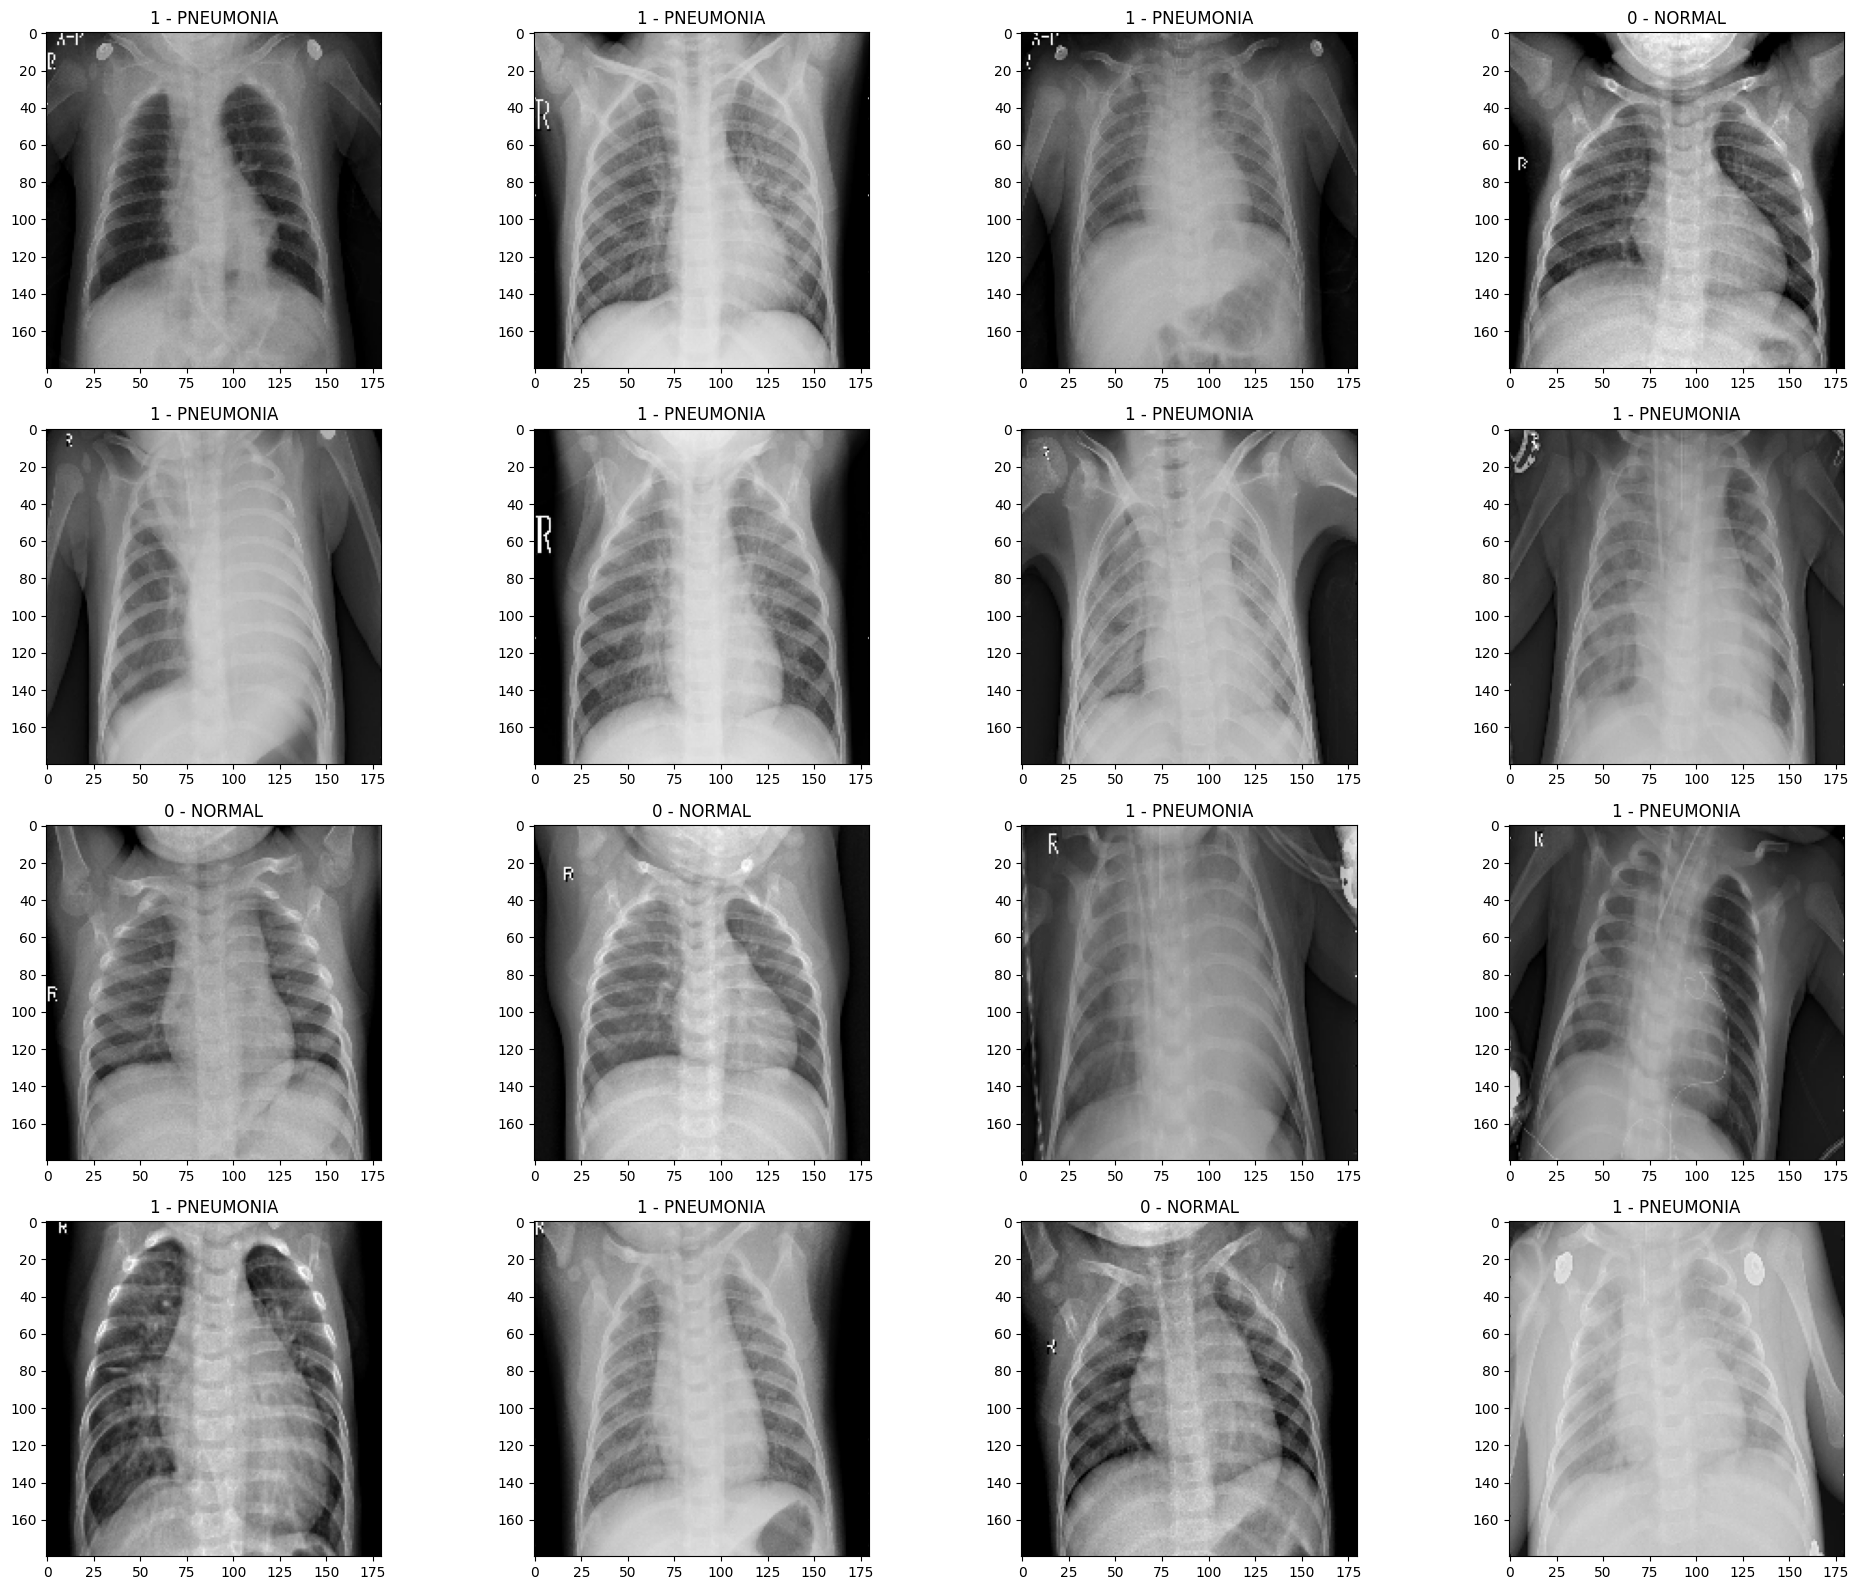

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20,16))
label_output = {0: 'NORMAL', 1: 'PNEUMONIA'}
i = range(16)

for i in range(16):
    ax = axes[i // 4][i % 4]
    ax.imshow(images_train[i], cmap='gray')
    ax.set_title(f'{labels_train[i]} - {label_output[labels_train[i]]}')
    
plt.tight_layout()
plt.show();

Modelling


In [17]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

# CREATE GENERATOR FOR TRAINING DATA (FROM train_df DATAFRAME)
resnet_train_generator = ImageDataGenerator(rescale=1.0/255).flow_from_dataframe(
    dataframe=train_df, x_col='image', y_col='label',
    color_mode='rgb',    # 3 channels
    class_mode='raw',
    target_size=IMG_SIZE, 
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True   # shuffle so we're not missing out on any samples
)

# CREATE GENERATOR FOR VALIDATION DATA (FROM val_df DATAFRAME)
resnet_val_generator = ImageDataGenerator(rescale=1.0/255).flow_from_dataframe(
    dataframe=val_df, x_col='image', y_col='label',
    color_mode='rgb',    # 3 channels   
    class_mode='raw',
    target_size=IMG_SIZE, 
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True
)

Found 4204 validated image filenames.
Found 1052 validated image filenames.


In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense
scania = Sequential()

# first layer would be NON-TRAINABLE (using pre-trained ResNet weights as is)
base_model = ResNet50(weights='imagenet',
                      include_top=False,
                      pooling='avg')
scania.add(base_model)
scania.add(Dense(1, activation='sigmoid'))

# freeze the weights of base model:
for layer in base_model.layers:
    layer.trainable = False

In [19]:
from tensorflow.keras.metrics import Recall, Precision
recall = Recall()
precision = Precision()

In [20]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.optimizers.schedules import ExponentialDecay

initial_learning_rate = 0.02
decay_rate = 0.01
decay_steps = 1000

lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps, decay_rate)
sgd = SGD(learning_rate=lr_schedule, momentum=0.9)
scania.compile(optimizer=sgd, 
              loss='binary_crossentropy',
              metrics=['accuracy', Recall(), Precision()])
scania.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


In [21]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=train_df['label'].unique(),
                                                  y=train_df['label'])

In [22]:
print(train_df['label'].unique())
print(class_weights)

[1 0]
[0.66900064 1.97928437]


In [23]:
class_weight = {0: class_weights[0], 1: class_weights[1]}
class_weight

{0: 0.6690006365372374, 1: 1.9792843691148776}

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np


checkpoint_cb = ModelCheckpoint('scania_2.0.h5',
                                save_best_only=True,
                                monitor='val_loss',
                                mode='min')
early_stopping_cb = EarlyStopping(patience=3,
                                  restore_best_weights=True,
                                  monitor='val_loss',
                                  mode='min')

EPOCHS = 5

results  = scania.fit(resnet_train_generator, 
                      validation_data=resnet_val_generator,
                      epochs=EPOCHS,
                      class_weight=class_weight,
                      steps_per_epoch=(resnet_train_generator.n//BATCH_SIZE),
                      validation_steps=(resnet_val_generator.n//BATCH_SIZE),
                      callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/5
131/131 [==============================] - 106s 779ms/step - loss: 2.0653 - accuracy: 0.7138 - recall_1: 0.9182 - precision_1: 0.7530 - val_loss: 0.4309 - val_accuracy: 0.7607 - val_recall_1: 0.9486 - val_precision_1: 0.7723
Epoch 2/5
131/131 [==============================] - 101s 770ms/step - loss: 0.5662 - accuracy: 0.7617 - recall_1: 0.9667 - precision_1: 0.7721 - val_loss: 0.8357 - val_accuracy: 0.7295 - val_recall_1: 1.0000 - val_precision_1: 0.7292
Epoch 3/5
131/131 [==============================] - 102s 775ms/step - loss: 0.4395 - accuracy: 0.7593 - recall_1: 0.9814 - precision_1: 0.7640 - val_loss: 0.4365 - val_accuracy: 0.7568 - val_recall_1: 0.9703 - val_precision_1: 0.7598
Epoch 4/5
131/131 [==============================] - 102s 777ms/step - loss: 0.4206 - accuracy: 0.7608 - recall_1: 0.9807 - precision_1: 0.7651 - val_loss: 0.4592 - val_accuracy: 0.7432 - val_recall_1: 0.9759 - val_precision_1: 0.7485


In [27]:
# unfreeze base_model layers:
for layer in base_model.layers:
    layer.trainable = True

In [28]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.optimizers.schedules import ExponentialDecay

initial_learning_rate = 0.01
decay_rate = 0.01
decay_steps = 1000

lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps, decay_rate)
sgd = SGD(learning_rate=lr_schedule, momentum=0.9)
scania.compile(optimizer=sgd, 
              loss='binary_crossentropy',
              metrics=['accuracy', Recall(), Precision()])
scania.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import numpy as np


checkpoint_cb = ModelCheckpoint('scania_2.0.h5',
                                save_best_only=True,
                                monitor='val_loss',
                                mode='min')
early_stopping_cb = EarlyStopping(patience=6,
                                  restore_best_weights=True,
                                  monitor='val_loss',
                                  mode='min')

EPOCHS = 10

results  = scania.fit(resnet_train_generator, 
                      validation_data=resnet_val_generator,
                      epochs=EPOCHS,
                      class_weight=class_weight,
                      steps_per_epoch=(resnet_train_generator.n//BATCH_SIZE),
                      validation_steps=(resnet_val_generator.n//BATCH_SIZE),
                      callbacks=[checkpoint_cb, early_stopping_cb])

In [ ]:
# VISUALIZE MODEL PERFORMANCE
def visualize_training_results(results):
    history = results.history
    
    for m in ['loss', 'accuracy', 'precision', 'recall']:
        plt.figure(figsize=(15,5))
        plt.plot(history[m], label='Training', marker='o', color='blue')
        plt.plot(history[f'val_{m}'], label='Validation', marker='o', color='red')
        plt.xlabel('Epochs')
        plt.legend()
        plt.title(m.title())
    
    plt.show();

In [ ]:
def plot_confusionmatrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    
    ax= plt.subplot()
    # annot=True to annotate cells, ftm='g' to disable scientific notation
    sns.heatmap(cm, annot=True, fmt='g', ax=ax)

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['NORMAL', 'PNEUMONIA'])
    ax.yaxis.set_ticklabels(['NORMAL', 'PNEUMONIA'])
    plt.show();